## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [64]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.linalg import eig

import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [65]:
half = sym.Rational(1,2)

b_modes = 2
t_modes = 2
# lets go for B2T2 (so 5 DoF)
p = mf.ModelParameters.DynamicModel(b_modes + t_modes)

## Create some global parameters
p.c = mf.ModelSymbol(value = 0.15,string = 'c') # chord of wing

p.rho_0 = mf.ModelSymbol(value = 2,string = 'rho_w') # mass per unit planform area

# main Wing Structural Parameters
p.y_0 = sym.Symbol('y_0')
p.x_0 = sym.Symbol('x_0')

p.e_0 = mf.ModelSymbol(value = 0,string = 'e_0')
p.x_f0 = mf.ModelSymbol(value = 0,string = 'x_f0') # sym.Rational(1,4)*p.c + p.e_0*p.c

p.s_0 = mf.ModelSymbol(value = 1.345,string = 's_0') # p.s_t*(1-p.ratio_fwt) # chord of wing

## force soome frequencies
p.f_0 = mf.ModelSymbol(value = 2,string = 'f_0') # first Bending mode frequency
p.EI = (2*sym.pi*p.f_0/sym.Float(3.516))**2*p.rho_0*p.c*(p.s_0)**4  # set EI to get desired frequency
#p.EI = mf.ModelSymbol(value = 59.375,string = 'EI')

p.f_1 = mf.ModelSymbol(value = 4,string = 'f_1') # first Torsional Mode
#p.I_0 = p.rho_t*p.c*(half*p.rho_t-p.x_f0)
#p.GJ = (sym.Rational(4,3)*p.f_1*(p.s_0+p.s_1))**2*p.I_0
p.GJ = mf.ModelSymbol(value = 855.625,string = 'GJ') # GJ for main wing

## Aero Parameters
p.rho = mf.ModelSymbol(value = 1.225,string = 'rho') # density
p.V = mf.ModelSymbol(value = 10,string = 'V') # velocity
p.g  = mf.ModelSymbol(value = 9.81,string = 'g') # gravity
p.alpha_r = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = mf.ModelSymbol(value = -1.2,string = 'M_thetadot')

## Main Wing Specific
p.a_0 = mf.ModelSymbol(value = 2*np.pi,string = 'a_0') # C_L of main wing

## Numeric Model Constants
p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}'))
p.eta = mf.ModelMatrix(value = [1]*b_modes+[1]*t_modes,symbols=sym.symbols(f'eta:{p.qs}'))

#### Create Transforms

In [66]:
#get shape functions for main wing
z_0,tau_0 = mf.ShapeFunctions_BN_TM(b_modes,t_modes,p.q[:],p.y_0,p.x_0,p.x_f0,0,factor=p.eta)

#define wrefernce frames
wing_root_frame = mf.HomogenousTransform().R_y(p.alpha_r)
wing_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0)
wing_flexural_frame = wing_frame.subs({p.x_0:p.x_f0})


#Create Elemnts
M_wing = ele.MassMatrix(p.rho_0)

inner_wing_ele = ele.FlexiElement(wing_root_frame,M_wing,p.x_0,p.y_0,z_0,p.c,p.s_0,p.x_f0,p.EI,p.GJ,gravityPot=False)

# Create Gravity forces
wing_GravityForces = ef.ContinuousGravityForce(p,wing_frame,
                                               sym.Matrix([0,0,-p.g*p.rho_0]),(p.x_0,0,p.c),(p.y_0,0,p.s_0))

# Create AeroForces
wing_AeroForces = ef.AeroForce.Generate(p,wing_flexural_frame,p.a_0,(p.y_0,0,p.s_0),
                               alphadot = tau_0 if isinstance(tau_0,int) else tau_0.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e_0,
                               rootAlpha = p.alpha_r,
                               deltaAlpha = tau_0,
                               alpha_zero = 0)

In [67]:
#Create Composite force
CompositeForce = ef.CompositeForce(p,[wing_AeroForces,])
#CompositeForce = ef.CompositeForce(p,[wing_AeroForces,fwt_AeroForces,wing_GravityForces])
inner_wing_ele._gravityPotential = True
# Create the SYmbolic Model
sm = mf.SymbolicModel.FromElementsAndForces(p,[inner_wing_ele],CompositeForce)

In [68]:
wing_AeroForces.Q().jacobian(p.qd)

⎡              5                   6                                     ⎤
⎢  -V⋅a₀⋅c⋅ρ⋅s₀        -V⋅a₀⋅c⋅ρ⋅s₀                                      ⎥
⎢  ──────────────      ──────────────           0                0       ⎥
⎢           2             12⋅η₀⋅η₁                                       ⎥
⎢      10⋅η₀                                                             ⎥
⎢                                                                        ⎥
⎢              6                   7                                     ⎥
⎢  -V⋅a₀⋅c⋅ρ⋅s₀        -V⋅a₀⋅c⋅ρ⋅s₀                                      ⎥
⎢  ──────────────      ──────────────           0                0       ⎥
⎢     12⋅η₀⋅η₁                  2                                        ⎥
⎢                          14⋅η₁                                         ⎥
⎢                                                                        ⎥
⎢       2        4          2        5           3     3          3     4⎥
⎢-V⋅a₀⋅c ⋅e₀⋅ρ⋅s₀    -V⋅a

# Setup Numeric Model Parameters


In [69]:
tmax, dt = 5, 0.01
ts = np.arange(0, tmax+dt, dt)

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 18

def arfunc(t,x):
    return np.deg2rad(5)
    #return np.deg2rad(5)+np.sin(2*np.pi*1*t)*np.deg2rad(5)
    
p.V.value = Vfunc
p.alpha_r.value = arfunc

constraints = [np.NaN]*p.qs*2
const_idx = np.isnan(constraints)

## Find the fixed point

## create masses 

In [74]:
y0 = [0]*p.qs*2

#sm_mini = sm
#sm_mini = sm_mini.subs(p,p.GetSubs(0,[0]*p.qs*2,ignore=[p.eta,p.EI,p.GJ,p.s_t,p.f_0,p.e_0,p.M_thetadot,p.V,p.alpha_1,p.alphadot_1,p.alpha_r]))

def objectiveDeriv(t,y):
    deriv = sm.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

In [76]:
p.V.value = 20
p.GJ.value = 80

p.s_0.value = 1.345
p.c.value = 0.15
p.rho_0.value = 5/(p.s_0.value*p.c.value)

val = 0.3
p.x_f0.value = p.c.value*val
p.e_0.value = p.c.value*(val-0.25)

p.M_thetadot.value = -1.2

p.f_0.value = 2

p.eta.value = [1,1,1,1]

def objectiveDeriv(t,y):
    deriv = sm.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

y0 = [0.1]*p.qs*2
yData = solve_ivp(objectiveDeriv,(0,1),y0)
#yData = solve_ivp(objectiveDeriv,(0,tmax),yi[:,-1])

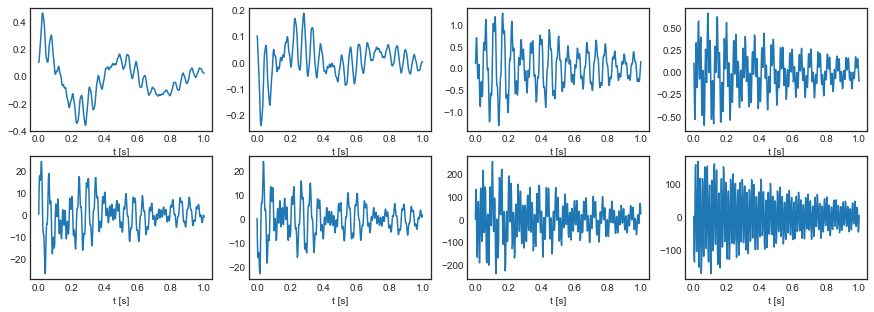

In [77]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    #axes[0][i].set(xlim=(0,0.1))
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')
    #axes[1][i].set(xlim=(0,0.1))

## Create the linearised EoM about some Stationary point

In [78]:
# get the linearised sm
sm_lin = sm.subs(p,p.GetSubs(0,p.fp,ignore=[p.V,p.GJ])).linearise(p)

# get eigen Matrices and turn into a function
K,M = sm_lin.eigenMatrices(p)

In [79]:
func = sym.lambdify((p.V,p.fp,p.GJ),(K,M),'numpy')

In [80]:
q = sym.Matrix(p.fp[::2])
qd = sym.Matrix(p.fp[1::2])
f = (sm.f-sm.ExtForces.Q())
f = (sm.f-sm.ExtForces.Q()).subs({p.x[i]:p.fp[i] for i in range(-1,-len(p.x)-1,-1)}).subs({i:0 for i in qd})
func_obj = sym.lambdify((q,p.V),(f.T*f).subs(p.GetSubs(0,q,ignore=[p.fp,p.V]))[0])


In [81]:
df = pd.DataFrame(columns=['v','aoa','q'])
vs = np.linspace(0,100,121)
pLast = [0]*p.qs
pLast[-1] = np.pi/2
for v in vs:
    p.V.value = v 
    pLast = minimize(func_obj,pLast,method='Powell',args=(v)).x
    v0 = [0]*p.qs
    y0 = [j for i in range(len(pLast)) for j in [pLast[i],v0[i]]]
    df = df.append({'aoa' : np.rad2deg(p.alpha_r(0,y0)), 'v' : v,'q':y0}, ignore_index=True)
    pLast
data = df

flutdfv2 = pd.DataFrame() 
for i in range(0,len(data)):  
    # get the fixed point
    #lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]

    # get the jacobian evaluated at this point
    #j_lp = func(data['v'].iloc[i],np.deg2rad(data['Lambda'].iloc[i]),ratio,lp)
    # get eigen value information
    #jac_dat = dof2.ExtractEigenValueData(j_lp,sortby='Damping')
    evals, evecs = eig(*func(data['v'].iloc[i],data['q'].iloc[i],p.GJ.value))
    jac_dat = mf.ExtractEigenValueData(evals,evecs,sortby='Frequency')

    # populate test specific data   
    jac_dat['V'] = data['v'].iloc[i]
    #jac_dat['Mass Ratio'] = f'r = {ratio}'
    y = np.array(data['q'].iloc[i])
    for i in range(len(y)):
        jac_dat[f'q_{i}'] =y[i]
    #jac_dat['Lambda'] = data['Lambda'].iloc[i]
    flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True)
#flutdfv2   

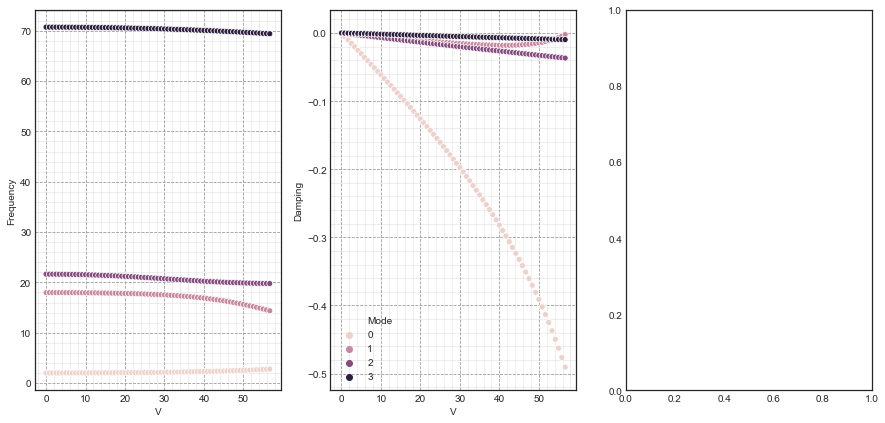

In [82]:
data = flutdfv2[flutdfv2['Stable']]
fig, axes = plt.subplots(1,3,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='Mode',ax=axes[0],legend=False)
sns.scatterplot(data=data,x='V',y='Damping',hue='Mode',ax=axes[1])
#sns.scatterplot(data=data,x='V',y=f'q_{p.qs*2-2}',ax=axes[2])


for i in [0,1]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,60))
#axes[0].set(ylim=(0.5,3))
#axes[0].set(ylim=(0,20))

In [83]:
flutdfv2[flutdfv2['Stable']]['V'].max()